# Evaluation
This notebook contains the code implemented to test the trained models

In [1]:
import torch
from tqdm import tqdm
import numpy as np
from data_handling import complete_data_preparation
from models import IMHAMomentumTransformer, SelfAttentionMomentumTransformer, GRUMomentumTransformer, CNNMomentumTransformer

## Loading Model

In [ ]:
model_name = "IMHAMomentumTransformer"
model_file_path = "modelDumps/" + model_name + ".pt"

model = torch.load(model_file_path)

## Evaluate the trained Model on the test batches

In [11]:
_, _, batches_test = complete_data_preparation(sequence_length=10, batch_size=64)

In [24]:
def evaluate(model, batches_test):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    lossFunction = torch.nn.MSELoss()

    model.to(device)
    model.eval()
    with torch.no_grad():
        totalLoss = 0
        for i in tqdm(range(len(batches_test))):
            # Prepare Data and move it to the appropriate device
            batch = batches_test[i]
            x = batch[:,:,:-1].to(device)
            t = batch[:,-1,-1].reshape(-1,1).to(device)

            # Forward pass: compute the model's predictions
            y = model(x)

            # Comput batch loss and store it
            loss = lossFunction(y, t)
            totalLoss += loss.item()
                
    return totalLoss

In [ ]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of Trainable Parameters: {trainable_params}')

In [ ]:
test_loss = evaluate(model, batches_test)
print(f'Test Loss: {test_loss}')

## Results Log

**Refererence Model and Modified Modles**
| Model | Hyperparameters|# Parameters | Test Loss |
|----------|----------|----------|----------|
| IMHA Momentum Transformer    | sequence_length = 10, batch_size = 64, n_head = 13, learning_rate = 0.005, epochs = 5, dropout_rate = 0.3, hidden_size = 25   | 119246   |3.9019851267221384   |
| Self-Attention Momentum Transformer    | sequence_length = 10, batch_size = 64, n_head = 13, learning_rate = 0.005, epochs = 5, dropout_rate = 0.2, hidden_size = 50   | 140206   |3.9260342489287723   |
| GRU Momentum Transformer    | sequence_length=10, batch_size=64, n_head=5, learning_rate=0.01, epochs=10, dropout_rate=0.3, hidden_size=50   | 126751   |4.01184778381139   |
| CNN Momentum Transformer    | sequence_length = 10, batch_size = 64, n_head = 5, learning_rate = 0.005, epochs = 5, dropout_rate = 0.2, hidden_size = 50, kernels = 32   | 101919   |3.907413617038401   |

**Benchmark Models**
| Model | Hyperparameters|# Parameters | Test Loss |
|----------|----------|----------|----------|
| LSTM    | sequence_length = 10, batch_size = 64, learning_rate = 0.005, epochs = 10, dropout_rate = 0.3, hidden_size = 50   | 23451  | 3.998927083594026   |
|Transformer (Encoder & Decoder)|sequence_length = 10, batch_size = 64, n_head = 4, learning_rate = 0.005, epochs = 3, dropout_rate = 0.3, hidden_size = 4|223205|4.068714729597559|
| Transformer Encoder    | sequence_length = 10, batch_size = 64, learning_rate = 0.005, epochs = 10, dropout_rate = 0.3, n_layer = 2, n_head = 5 | 154701 |4.125702866062056
|Random Forest|n_estimators=100, max_depth=30, sequence_length=3, batch_size=64|701328 (Number of Leaf Nodes)|5.415680542938186 (estimated based on test data subset)|
|Constantly Guessing Training Mean|Not Applicable|0|4.0670643|

In [37]:
# Loss of always guessing 0
lossFunction = torch.nn.MSELoss()
batches_train, _, batches_test = complete_data_preparation(sequence_length=10, batch_size=64)

torch.mean(torch.cat([batch[:,-1,-1].reshape(1,-1) for batch in batches_train], dim=1))
np.sum([lossFunction(batch[:,-1,-1].reshape(-1,1), torch.ones(batch.size(0), 1)*0.1083) for batch in batches_test])

4.0670643

In [1]:
model_names = ["IMHA Momentum Transformer", "Self-Attention Momentum Transformer", "GRU Momentum Transformer", "CNN Momentum Transformer", "LSTM", "Transformer (Encoder & Decoder)", "Transformer Encoder", "Random Forest"]
banchmark_model = [False, False, False, False, True, True, True, True]
model_errors = [3.9019851267221384, 3.9260342489287723, 4.01184778381139, 3.907413617038401,  3.998927083594026, 4.068714729597559, 4.125702866062056, 5.415680542938186]
model_n_params = [119246, 140206, 126751, 101919, 23451, 223205, 154701, 701328]

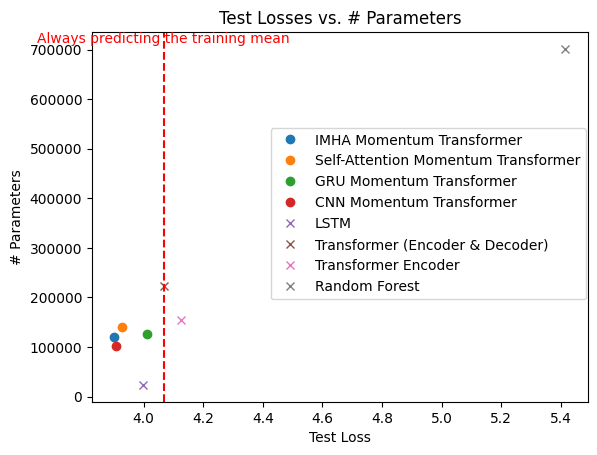

In [2]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)

for i, name in enumerate(model_names):
    ax.plot(model_errors[i], model_n_params[i], 'x' if banchmark_model[i] else 'o')
    ax.legend(model_names, bbox_to_anchor=(1.01, 0.76))

ax.axvline(x=4.0670643, color='r', linestyle='--')
ax.text(4.0676043, plt.gca().get_ylim()[1], 'Always predicting the training mean', color='red', va='top', ha='center')


plt.xlabel('Test Loss')
plt.ylabel('# Parameters')
plt.title('Test Losses vs. # Parameters')  # Main title

plt.show()